### Задача:

* проанализировать АБ тест, проведенный на реальных пользователях Яндекса
* подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
* определить характер этих изменений и практическую значимость вводимого изменения
* понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

### Описание данных:

* `userID`: уникальный идентификатор пользователя
* `browser`: браузер, который использовал `userID`
* `slot`: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* `n_clicks`: количество кликов, которые пользоваль совершил за `n_queries`
* `n_queries`: количество запросов, который совершил `userID`, пользуясь браузером `browser`
* `n_nonclk_queries`: количество запросов пользователя, в которых им не было совершено ни одного клика

Не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [163]:
import numpy as np
import pandas as pd

from statsmodels.stats.weightstats import *
from statsmodels.sandbox.stats.multicomp import multipletests 

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [64]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [65]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(
        stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [66]:
data = pd.read_csv("ab_browser_test.csv")
data.shape

(566134, 6)

In [67]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [68]:
data.slot.value_counts()

control    284554
exp        281580
Name: slot, dtype: int64

### Решение

#### Задача 1
Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки. 

In [69]:
n_clicks = data.groupby('slot')[['n_clicks']].sum()
n_clicks

,n_clicks
slot,
control,3210027
exp,3261823


In [70]:
print("Answer: {:.3f}".format(
    (n_clicks.loc['exp']/n_clicks.loc['control'] - 1).values[0]*100))

Answer: 1.614


#### Задача 2
Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения. 

In [71]:
np.random.seed(0)

exp_median = list(
    map(np.median, get_bootstrap_samples(data.n_clicks[data.slot == 'exp'].values, 1000)))
control_median = list(
    map(np.median, get_bootstrap_samples(data.n_clicks[data.slot == 'control'].values, 1000)))

print("95% confidence interval for the median number of clicks in experimental group:",
      stat_intervals(exp_median, 0.05))
print("95% confidence interval for the median number of clicks in control group:",
      stat_intervals(control_median, 0.05))

95% confidence interval for the median number of clicks in experimental group: [5. 5.]
95% confidence interval for the median number of clicks in control group: [4. 4.]


In [72]:
delta_median_scores = list(
    map(lambda x: x[1] - x[0], 
        zip(exp_median, control_median)))

print("95% confidence interval for the difference between medians",
      stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [-1. -1.]


95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы отличаются статистически значимо

In [73]:
np.random.seed(0)

exp_mean = list(
    map(np.mean, get_bootstrap_samples(data.n_clicks[data.slot == 'exp'].values, 1000)))
control_mean = list(
    map(np.mean, get_bootstrap_samples(data.n_clicks[data.slot == 'control'].values, 1000)))

print("95% confidence interval for the mean number of clicks in experimental group:",
      stat_intervals(exp_mean, 0.05))
print("95% confidence interval for the mean number of clicks in control group:",
      stat_intervals(control_mean, 0.05))

95% confidence interval for the mean number of clicks in experimental group: [11.5086867  11.66089388]
95% confidence interval for the mean number of clicks in control group: [11.20795095 11.35742732]


In [74]:
delta_mean_scores = list(
    map(lambda x: x[1] - x[0], 
        zip(exp_mean, control_mean)))

print("95% confidence interval for the difference between medians",
      stat_intervals(delta_mean_scores, 0.05))

95% confidence interval for the difference between medians [-0.40475697 -0.19172563]


95% доверительный интервал для разности средних не содержит ноль, похоже, средние отличаются статистически значимо

### Задача 3
Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах. 

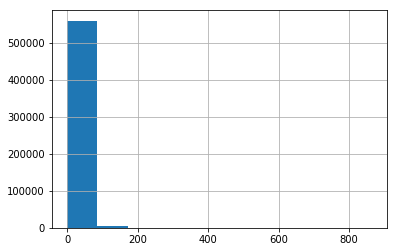

In [75]:
data.n_clicks.hist();

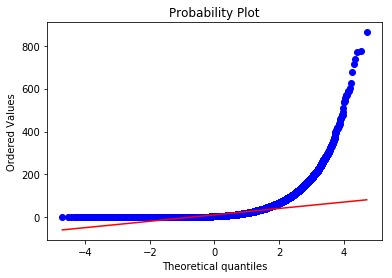

In [76]:
stats.probplot(data.n_clicks, dist="norm", plot=pylab)
pylab.show()

### Задача 4

1. Получите из данных `n_boot_samples` псевдовыборок. 

In [77]:
np.random.seed(0)
n_boot_samples = 500
boot_samples = get_bootstrap_samples(data.n_clicks.values, n_boot_samples)

2. По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (`control_boot_chi_squared`) 

In [78]:
boot_mean = list(map(np.mean, boot_samples))

3. Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения

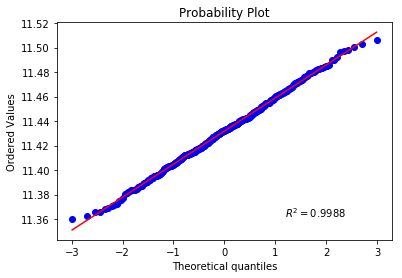

In [79]:
stats.probplot(boot_mean, dist="norm", plot=pylab, rvalue=True);

In [80]:
def boot_chi_squared(sample):
    sample_mean = np.mean(sample)
    return np.sum(np.power((sample-sample_mean), 2))

In [81]:
control_boot_chi_squared = list(map(boot_chi_squared, boot_samples))

4. Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды 

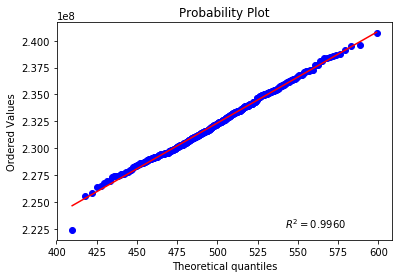

In [82]:
stats.probplot(control_boot_chi_squared, dist="chi2",
               sparams=(len(control_boot_chi_squared)-1), plot=pylab, rvalue=True);

5. Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

    Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ?

In [139]:
clicks_dict = {i: 0 for i in data.userID.value_counts().index}

for i in range(len(data)):
    clicks_dict[data.userID.values[i]] += data.n_clicks.values[i]

clicks_pd = pd.DataFrame(data=list(clicks_dict.items()),
                         columns=['userID', 'clicks'])

In [140]:
clicks_pd = clicks_pd.merge(data[['userID', 'slot']], on=['userID'], how='left').drop_duplicates()

In [141]:
clicks_pd.head()

,userID,clicks,slot
0,187470,7,control
2,6989,10,exp
4,15820,24,control
6,129663,19,exp
8,259459,6,exp


In [147]:
stats.mannwhitneyu(clicks_pd[clicks_pd.slot=='exp'].clicks, 
                   clicks_pd[clicks_pd.slot=='control'].clicks)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

6. Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

    Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с $\alpha=0.05$.

    Какое заключение можно сделать исходя из полученных результатов?

    В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [157]:
data_exp = data[data.slot == 'exp']
data_control = data[data.slot == 'control']

In [162]:
mw = [stats.mannwhitneyu(data_exp[data_exp.browser == browser].n_clicks,
                         data_control[data_control.browser == browser].n_clicks) for browser in data.browser.unique()]

In [172]:
reject, p_corrected, a1, a2 = multipletests([l.pvalue for l in mw],
                                            alpha=0.05,
                                            method='holm')

In [188]:
len(reject) - sum(reject)

5

In [187]:
stats.mannwhitneyu?

7. Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

    Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения. 

In [185]:
browsers = data.browser.unique()

no_clicks_exp = [np.sum(data_exp[data_exp.browser == browser].n_nonclk_queries) /
                 np.sum(data_exp[data_exp.browser == browser].n_queries)*100 for browser in browsers]

no_clicks_control = [np.sum(data_control[data_control.browser == browser].n_nonclk_queries) /
                     np.sum(data_control[data_control.browser == browser].n_queries)*100 for browser in browsers]

pd.DataFrame([no_clicks_exp, no_clicks_control], index=['exp', 'control'], columns=browsers).T

,exp,control
Browser #2,44.982747,45.962747
Browser #4,45.142942,46.970930
Browser #14,43.755617,57.590411
Browser #17,36.937413,36.299367
Browser #20,38.977376,40.540485
Browser #22,39.853947,40.593977
